In [2]:
# all imports
import numpy as np
import os
import requests
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import math
import matplotlib as mpl
from astropy.visualization.wcsaxes import SphericalCircle
import pandas as pd
import random
from matplotlib.patches import Ellipse
import ligo.skymap.plot

In [3]:
# define directories
data_dir = '/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/'
cache_dir = '/pscratch/sd/j/jjpim/cache/' # my cache path
vi_dir = '/pscratch/sd/j/jjpim/visual_inspection/' # vi image path
v_dir = '/pscratch/sd/j/jjpim/2Dvmap/' # 2D velocity map image path

In [4]:
# load updated fuji table
tf_fuji = Table.read(data_dir + 'SV/desi_pv_tf_fuji_healpix_rotcurve_EOA_VI_velocity.fits') 
# load iron table
tf_iron = Table.read(data_dir + 'Y1/desi_pv_tf_iron_healpix_rotcurve_EOA_VI_velocity.fits')
#combine
tf_mastertable = vstack([tf_fuji,tf_iron])
#unique SGA IDs in rot curve galaxies
tf_galaxies = np.unique(tf_mastertable['SGA_ID'][tf_mastertable['ROT_CURVE']==1])
tf_mastertable_dict = {}
for sga_id in np.unique(tf_mastertable['SGA_ID'][tf_mastertable['ROT_CURVE']==1]):
    tf_mastertable_dict[sga_id] = np.where(tf_mastertable['SGA_ID'] == sga_id)[0]
tf_mastertable[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC,OBS_IN_SV,SKY_FIBER_DIST,SKY_FIBER_DIST_R26,ROT_CURVE,EOA,VELOCITY,VERR
int64,float64,float64,int64,bytes4,float64,float64,int64,float64,bytes65,bytes3,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1079550234591232,194.390863195343,27.5157211790145,10378,sv3,1.1235686466514,7.31685779475115e-05,4,3.28414569795132,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.39086319534337,27.51572117901454,1.0,0.03927420444753712,1.0000000170652443,0.0,0.0,--,inf
1092744374124544,194.390863195343,27.5157211790145,10378,sv3,0.686773088332363,6.9756676262104e-05,4,0.786607094109058,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.39086319534337,27.51572117901454,1.0,0.03927420444753712,1.0000000170652443,0.0,0.0,--,inf
1092744374124546,194.364461113654,27.5037185881314,10378,sv3,0.0242933923052181,4.95233472646785e-05,0,95.428411073226,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.36446111365385,27.50371858813136,1.0,0.012960487467698754,0.3300000056318236,0.0,0.0,--,inf
1092744369930240,194.338458724402,27.4918902690326,10378,sv3,0.0264170223697961,0.00010139452689994,0,9.53278421035066,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.33845872440244,27.491890269032595,1.0,0.012960487467685656,0.33000000563149007,0.0,0.0,--,inf
1092744374124545,194.377858465028,27.5098100780282,10378,sv3,0.211332646769145,6.68535116703737e-05,4,3.73989077657461,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3778584650283,27.509810078028195,1.0,0.026313716979861984,0.6700000114340222,0.0,0.0,--,inf


In [5]:
# load SGA table
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')
SGA_dict = {}
for i in range(len(SGA)):
    SGA_dict[SGA['SGA_ID'][i]] = i
SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

In [14]:
SGA[SGA_dict[1356809]]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
1356809,SGA-2020 1356809,PGC2397606,2397606,215.765889,51.648329100000005,E?,62.16,0.41020408,0.52480745,0.06744399,24.957481,18.264,False,LEDA-20181114,498645,PGC2397606,1,True,215.765889,51.648329100000005,0.41020408,2156p517,215.76586073054855,51.648309628152944,0.61573845,SB26,62.995987,0.2754777,215.76566257225795,51.64836198616958,11.533378,6.031899,5.4864492,5.2701077,5.9194326,7.547172,8.985081,10.353915,11.649269,12.836066,14.457049,16.69346,18.472153,18.570166,17.51929,16.81079,18.28923,17.26936,16.575014,18.117554,17.118614,16.432013,18.01008,17.02439,16.334513,17.942015,16.97347,16.28297,17.895414,16.938984,16.24697,17.860844,16.908245,16.224113,17.830423,16.886007,16.203508,17.8195,16.873234,16.189863,0.08099191,0.08182129,0.12838417,0.10712533,0.1507002,0.12652121,0.15332921,0.21707046,0.10071385,0.045562677,0.05196177,0.053235095,0.041383177,0.046439458,0.04740494,0.038865402,0.043214608,0.04391064,0.036964353,0.040939096,0.041458946,0.0356235,0.039579988,0.040019784,0.03459745,0.038601503,0.038977236,0.03370701,0.03762645,0.038207527,0.03289086,0.0369175,0.037543673,0.032596763,0.036521133,0.037161123,17.794567,0.30792016,1.1732483,4.3390164,0.009680596,16.854677,0.30444172,0.88728654,4.1701827,0.018238412,16.179953,0.22325847,1.223124,4.893565,0.031483278,0


In [ ]:
#find sga id with certain amount of targets
for sga_id in tf_galaxies:
    if len(tf_mastertable[tf_mastertable['SGA_ID']==  sga_id])>10 and len(tf_mastertable[tf_mastertable['SGA_ID']==  sga_id])<12:
        print(sga_id)

In [15]:
tf_mastertable[tf_mastertable['SGA_ID']==  10325]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC,OBS_IN_SV,SKY_FIBER_DIST,SKY_FIBER_DIST_R26,ROT_CURVE,EOA,VELOCITY,VERR
int64,float64,float64,int64,bytes4,float64,float64,int64,float64,bytes65,bytes3,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633419147150407,191.036095213896,62.8669555491134,11231,sv3,0.0740987426539169,5.01190329019023e-06,0,1698.80562620983,fuji/healpix/sv3/bright/112/11231/redrock-sv3-bright-11231.fits,TFT,10325,191.03609521389586,62.86695554911338,1.0,0.0,0.0,1.0,0.0,-0.16843259059563068,1.852898955735944
1071347337789446,191.033380723789,62.8663448984112,11231,sv3,0.0744364780905412,1.50867109400207e-05,0,134.51843894273,fuji/healpix/sv3/bright/112/11231/redrock-sv3-bright-11231.fits,TFT,10325,191.03338072378898,62.866344898411185,1.0,0.0013803930545818583,0.3299999991681249,1.0,0.0,101.08210410870586,4.651032004938977
1084541477322758,191.033380723789,62.8663448984112,11231,sv3,0.0744473940843154,7.99943279233705e-06,0,861.901231005788,fuji/healpix/sv3/dark/112/11231/redrock-sv3-dark-11231.fits,TFT,10325,191.03338072378898,62.866344898411185,1.0,0.0013803930545818583,0.3299999991681249,1.0,0.0,104.35463671378659,2.6318915704913697
1071347337789444,191.027869833637,62.8651049318809,11231,sv3,0.00527985095866949,7.70547202014481e-05,4,1.64519945304437,fuji/healpix/sv3/bright/112/11231/redrock-sv3-bright-11231.fits,TFT,10325,191.02786983363657,62.865104931880865,1.0,0.004183009256296153,0.999999997476176,1.0,0.0,-20631.553130744604,23.125856163501116
1084541477322756,191.027869833637,62.8651049318809,11231,sv3,0.972354722184889,0.000259315167586565,4,2.94638759456575,fuji/healpix/sv3/dark/112/11231/redrock-sv3-dark-11231.fits,TFT,10325,191.02786983363657,62.865104931880865,1.0,0.004183009256296153,0.999999997476176,1.0,0.0,269290.19958419725,77.74829237944968
1071347337789445,191.0305840945,62.8657156885509,11231,sv3,1.00324368337051,0.000112727385509732,4,3.20785985887051,fuji/healpix/sv3/bright/112/11231/redrock-sv3-bright-11231.fits,TFT,10325,191.03058409450014,62.86571568855088,1.0,0.0028026162017238203,0.6699999983103283,1.0,0.0,278550.4771831012,33.812209238573644
1084541477322757,191.0305840945,62.8657156885509,11231,sv3,0.524324473758907,6.72555408859889e-05,4,5.89843332767487,fuji/healpix/sv3/dark/112/11231/redrock-sv3-dark-11231.fits,TFT,10325,191.03058409450014,62.86571568855088,1.0,0.0028026162017238203,0.6699999983103283,1.0,0.0,134974.11015022144,20.19183659137785
1071347337789448,191.041606798713,62.8681951945069,11231,sv3,1.41717322699328,0.000100145191297347,4,1.80413293838501,fuji/healpix/sv3/bright/112/11231/redrock-sv3-bright-11231.fits,TFT,10325,191.04160679871254,62.86819519450693,1.0,0.0028026162017131023,0.669999998307766,1.0,0.0,402643.43250458955,30.042345742003896
1084541477322760,191.041606798713,62.8681951945069,11231,sv3,0.631423898133023,0.000102843867926925,4,2.24057418107986,fuji/healpix/sv3/dark/112/11231/redrock-sv3-dark-11231.fits,TFT,10325,191.04160679871254,62.86819519450693,1.0,0.0028026162017131023,0.669999998307766,1.0,0.0,167081.7098337228,30.850875366226603


some plots have no center-- check colorbar scale, might be such a narrow scale that the center appears as dark red/blue

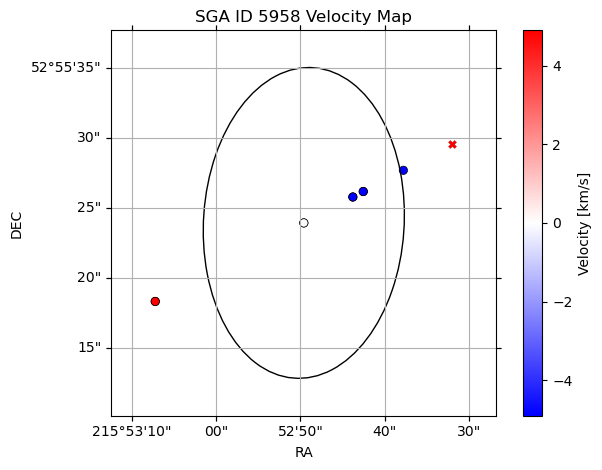

In [89]:
plt.close('all')
sga_id = 5958
galaxy = tf_mastertable[tf_mastertable['SGA_ID'] == sga_id]
c = galaxy['VELOCITY']

# find max of absolute value of the leftover velocities
velocity_abs = np.abs(c)
v_max = np.max(velocity_abs)

# separate the data into velocity types
high_velocity = galaxy[np.abs(c) > 1000]
low_velocity = galaxy[np.abs(c) <= 1000]

if len(low_velocity) > 0:
    first_low_velocity = low_velocity['VELOCITY'][0]
    vmin = -np.abs(first_low_velocity)
    vmax = np.abs(first_low_velocity)    
else:
    # if there are no low velocity data points set range as -1000 to 1000
    vmin = -1000 if v_max > 1000 else -v_max
    vmax = 1000 if v_max > 1000 else v_max
    
    
#ellipse center and position angle (degrees)
x_center = SGA['RA'][SGA_dict[sga_id]]
y_center = SGA['DEC'][SGA_dict[sga_id]]
theta = SGA['PA'][SGA_dict[sga_id]]

#put major and minor axis into degrees
maj = SGA['D26'][SGA_dict[sga_id]]
major = maj/60
ratio = SGA['BA'][SGA_dict[sga_id]]
min_axis = maj*ratio
minor = major*ratio

#set up to plot w/transform
ellipse_center = SkyCoord(ra = x_center * u.degree, dec = y_center * u.degree)
major_radius = np.arctan(major*0.01) * u.radian

fig = plt.figure(tight_layout=True)

ax_sky = plt.subplot(111, projection='astro degrees zoom', center=ellipse_center, radius=major_radius)
ax_sky.grid()

abc = ax_sky.scatter(high_velocity['RA'], 
               high_velocity['DEC'], 
               c=high_velocity['VELOCITY'], 
               marker='X', 
               cmap='bwr', 
               linewidths=0.1, 
               edgecolors='black', 
               vmin = vmin, 
               vmax = vmax,
               transform=ax_sky.get_transform('world'))
    
bcd = ax_sky.scatter(low_velocity['RA'], 
               low_velocity['DEC'], 
               c=low_velocity['VELOCITY'], 
               marker='o', 
               cmap='bwr', 
               linewidths=0.5, 
               edgecolors='black', 
               vmin=vmin, 
               vmax = vmax,
               transform=ax_sky.get_transform('world'))

# plot w/ color bar
fig.colorbar(bcd, label='Velocity [km/s]', ax=ax_sky)
ax_sky.set_xlabel('RA')
ax_sky.set_ylabel('DEC')
ax_sky.set_title('SGA ID {} Velocity Map'.format(galaxy['SGA_ID'][0]))

vertex1 = ellipse_center.directional_offset_by(theta*u.deg, 0.5*maj*u.arcmin)

phi = np.arctan((vertex1.ra - ellipse_center.ra)/(vertex1.dec - ellipse_center.dec)).to('deg')

# plotting ellipse
ell = Ellipse(
    xy = (x_center, y_center),
    width = minor,
    height = major,
    angle = (180 - phi.value),
    edgecolor = 'black',
    facecolor = 'none',
    transform=ax_sky.get_transform('world')
    )
ax_sky.add_artist(ell)
plt.show()

In [ ]:
for sga_id in tf_galaxies:
    galaxy = tf_mastertable[tf_mastertable['SGA_ID'] == sga_id]
    c = galaxy['VELOCITY']

    # find max of absolute value of the leftover velocities
    velocity_abs = np.abs(c)
    v_max = np.max(velocity_abs)

    # separate the data into velocity types
    high_velocity = galaxy[np.abs(c) > 1000]
    low_velocity = galaxy[np.abs(c) <= 1000]

    if len(low_velocity) > 0:
        first_low_velocity = low_velocity['VELOCITY'][0]
        vmin = -np.abs(first_low_velocity)
        vmax = np.abs(first_low_velocity)    
    else:
        # if there are no low velocity data points set range as -1000 to 1000
        vmin = -1000 if v_max > 1000 else -v_max
        vmax = 1000 if v_max > 1000 else v_max
    
    
    #ellipse center and position angle (degrees)
    x_center = SGA['RA'][SGA_dict[sga_id]]
    y_center = SGA['DEC'][SGA_dict[sga_id]]
    theta = SGA['PA'][SGA_dict[sga_id]]

    #put major and minor axis into degrees
    maj = SGA['D26'][SGA_dict[sga_id]]
    major = maj/60
    ratio = SGA['BA'][SGA_dict[sga_id]]
    min_axis = maj*ratio
    minor = major*ratio

    #set up to plot w/transform
    ellipse_center = SkyCoord(ra = x_center * u.degree, dec = y_center * u.degree)
    major_radius = np.arctan(major*0.01) * u.radian

    fig = plt.figure(tight_layout=True)

    ax_sky = plt.subplot(111, projection='astro degrees zoom', center=ellipse_center, radius=major_radius)

    abc = ax_sky.scatter(high_velocity['RA'], 
               high_velocity['DEC'], 
               c=high_velocity['VELOCITY'], 
               marker='X', 
               cmap='bwr', 
               linewidths=0.1, 
               edgecolors='black', 
               vmin = vmin, 
               vmax = vmax,
               transform=ax_sky.get_transform('world'))
    
    bcd = ax_sky.scatter(low_velocity['RA'], 
               low_velocity['DEC'], 
               c=low_velocity['VELOCITY'], 
               marker='o', 
               cmap='bwr', 
               linewidths=0.5, 
               edgecolors='black', 
               vmin=vmin, 
               vmax = vmax,
               transform=ax_sky.get_transform('world'))

    # plot w/ color bar
    fig.colorbar(bcd, label='Velocity [km/s]', ax=ax_sky)
    ax_sky.set_xlabel('RA')
    ax_sky.set_ylabel('DEC')
    ax_sky.set_title('SGA ID {} Velocity Map'.format(galaxy['SGA_ID'][0]))

    vertex1 = ellipse_center.directional_offset_by(theta*u.deg, 0.5*maj*u.arcmin)

    phi = np.arctan((vertex1.ra - ellipse_center.ra)/(vertex1.dec - ellipse_center.dec)).to('deg')

    # plotting ellipse
    ell = Ellipse(
        xy = (x_center, y_center),
        width = minor,
        height = major,
        angle = (180 - phi.value),
        edgecolor = 'black',
        facecolor = 'none',
        transform=ax_sky.get_transform('world')
        )
    ax_sky.add_artist(ell)
    img_name = v_dir + '{}.jpg'.format(sga_id)
    plt.savefig(v_dir + '{}.png'.format(sga_id), dpi=120)
    '''if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        plt.savefig(v_dir + '{}.png'.format(sga_id), dpi=120)
    '''
    plt.show()

In [62]:
print(180-phi.value)
print(phi.value)
print(vertex1)

252.3254148409219
-72.32541484092191
<SkyCoord (ICRS): (ra, dec) in deg
    (215.88533457, 52.92176436)>


In [42]:
ell.get_vertices()

[(215.88362121016692, 52.92231032441092),
 (215.87726470078908, 52.92433583901292)]

In [39]:
high_velocity[['RA','DEC']]

RA,DEC
float64,float64
235.89767909946755,43.84503395695681
235.90101343657693,43.837924200001574
235.90035461859102,43.839329129719665


In [22]:
vertex1 = ellipse_center.directional_offset_by(theta*u.deg, 0.5*maj*u.arcmin)
vertex2 = ellipse_center.directional_offset_by(theta*u.deg + 180*u.deg, 0.5*maj*u.arcmin)
print(vertex1, vertex2)

<SkyCoord (ICRS): (ra, dec) in deg
    (215.88533457, 52.92176436)> <SkyCoord (ICRS): (ra, dec) in deg
    (215.87555098, 52.92488161)>


In [23]:
[(vertex1.ra.value, vertex1.dec.value), (vertex2.ra.value, vertex2.dec.value)]

[(215.8853345746458, 52.92176435734562),
 (215.87555098410664, 52.92488160518876)]

In [25]:
phi = np.arctan((vertex1.ra - ellipse_center.ra)/(vertex1.dec - ellipse_center.dec)).to('deg')
phi.value

-72.32541484092191

In [ ]:
for sga_id in tf_galaxies:
    galaxy = tf_mastertable[tf_mastertable['SGA_ID'] == sga_id]
    c = galaxy['VELOCITY']

    # find max of absolute value of the leftover velocities
    velocity_abs = np.abs(c)
    v_max = np.max(velocity_abs)

    # separate the data into velocity types
    high_velocity = galaxy[np.abs(c) > 1000]
    low_velocity = galaxy[np.abs(c) <= 1000]

    if len(low_velocity) > 0:
        first_low_velocity = low_velocity['VELOCITY'][0]
        vmin = -np.abs(first_low_velocity)
        vmax = np.abs(first_low_velocity)    
    else:
        # if there are no low velocity data points set range as -1000 to 1000
        vmin = -1000 if v_max > 1000 else -v_max
        vmax = 1000 if v_max > 1000 else v_max
    
    
    #ellipse center and position angle (degrees)
    x_center = SGA['RA'][SGA_dict[sga_id]]
    y_center = SGA['DEC'][SGA_dict[sga_id]]
    theta = SGA['PA'][SGA_dict[sga_id]]

    #put major and minor axis into degrees
    maj = SGA['D26'][SGA_dict[sga_id]]
    major = maj/60
    ratio = SGA['BA'][SGA_dict[sga_id]]
    min_axis = maj*ratio
    minor = major*ratio

    #set up to plot w/transform
    ellipse_center = SkyCoord(ra=x_center * u.degree, dec=y_center * u.degree)
    major_radius = np.arctan(major*0.01) * u.radian

    fig = plt.figure(tight_layout=True)

    ax_sky = plt.subplot(111, projection='astro degrees zoom', center=ellipse_center, radius=major_radius)
    #ax_sky.grid

    abc = ax_sky.scatter(high_velocity['RA'], 
               high_velocity['DEC'], 
               c=high_velocity['VELOCITY'], 
               marker='X', 
               cmap='bwr', 
               linewidths=0.1, 
               edgecolors='black', 
               vmin = vmin, 
               vmax = vmax,
               transform=ax_sky.get_transform('world'))
    
    bcd = ax_sky.scatter(low_velocity['RA'], 
               low_velocity['DEC'], 
               c=low_velocity['VELOCITY'], 
               marker='o', 
               cmap='bwr', 
               linewidths=0.5, 
               edgecolors='black', 
               vmin=vmin, 
               vmax = vmax,
               transform=ax_sky.get_transform('world'))

    # plot w/ color bar
    fig.colorbar(bcd, label='Velocity [km/s]', ax=ax_sky)
    ax_sky.set_xlabel('RA')
    ax_sky.set_ylabel('DEC')
    ax_sky.set_title('SGA ID {} Velocity Map'.format(galaxy['SGA_ID'][0]))

    vertex1 = ellipse_center.directional_offset_by(theta*u.deg, 0.5*maj*u.arcmin)
    #vertex2 = ellipse_center.directional_offset_by(theta*u.deg + 180*u.deg, 0.5*maj*u.arcmin)

    #vertex3 = ellipse_center.directional_offset_by(theta*u.deg + 90*u.deg, 0.5*min_axis*u.arcmin)
    #vertex4 = ellipse_center.directional_offset_by(theta*u.deg + 270*u.deg, 0.5*min_axis*u.arcmin)

    phi = np.arctan((vertex1.ra - ellipse_center.ra)/(vertex1.dec - ellipse_center.dec)).to('deg')

    # plotting ellipse
    ell = Ellipse(
        xy = (x_center, y_center),
        width = minor,
        height = major,
        #angle =(180 - theta), #accounts for differences between matplotlib and legacy survey units
        angle = 180 - phi.value,
        #vertices = [(vertex1.ra.value, vertex1.dec.value), (vertex2.ra.value, vertex2.dec.value)],
        #co_vertices = [(vertex3.ra.value, vertex3.dec.value), (vertex4.ra.value, vertex4.dec.value)],
        edgecolor = 'black',
        facecolor = 'none',
        transform=ax_sky.get_transform('world')
        )
    ax_sky.add_artist(ell)
    # either load an existing image or save fig to scratch
    img_name = os.path.join(v_dir, '{}.jpg'.format(sga_id))
    plt.savefig(os.path.join(v_dir, '{}.png'.format(sga_id)), dpi=120)
    plt.show()